# How to generate a simulated timeline and produce a map with `litebird_sim`

**Attention! This notebook can work only after having downloaded the Litebird IMO information.**

You will have to ask the permission to access the private repository https://github.com/litebird/litebird_imo and then install it following [the documentation](https://litebird-sim.readthedocs.io/en/master/tutorial.html#interacting-with-the-imo).

To run this notebook, you should create and activate a new virtual environment with the commands

```
python -m venv ./my_venv
source ./my_venv/bin/activate
```

(you can use Conda environments, if you prefer) and install Jupyter and litebird_sim in it:

```
pip install jupyter litebird_sim
```

If you have a local copy of the `litebird_sim` repository cloned from <https://github.com/litebird/litebird_sim> (e.g., because you're part of the Simulation Team!), you can use a *development install* instead:

```
cd /my/local/copy/litebird_sim
pip install -e .
```

## Set up the environment

We start by importing a few libraries that will be useful in this notebook.

In [1]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from astropy.time import Time

%matplotlib inline

TOAST INFO: mpi4py not found- using serial operations only


# Produce a simualted timeline


We will simulate 4 detectors of 140 GHz MFT. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version 1.3 (**new!**), and we will simulate 2 hours of observation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/simulations.html#simulations) for more details about the input parameters.

In [2]:
telescope = "MFT"
channel = "M1-140"
detlist = ["001_002_060_45A_140_T",
           "001_003_000_75A_140_B",
           "001_003_001_15B_140_T",
           "001_003_002_60A_140_B"]

start_time = Time("2025-01-01T00:00:00")
mission_time_hours = 1

imo_version = "v1.3"

# Resolution of the input maps
nside = 256

In [3]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    start_time=start_time,
    duration_s=mission_time_hours * 3600.0,
)

The following instructions load from the IMO the information about the [instrument](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) and the [detectors](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) used in the simulation.

In [4]:
# Load the definition of the instrument (LFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

dets = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    dets.append(det)

[2023-02-15 09:10:56,218 WARNING MPI#0000] Band is not apodized
[2023-02-15 09:10:56,219 WARNING MPI#0000] Band is not apodized
[2023-02-15 09:10:56,220 WARNING MPI#0000] Band is not apodized
[2023-02-15 09:10:56,222 WARNING MPI#0000] Band is not apodized


Now we set the scanning strategy retriving the parameters from the IMO

In [5]:
# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

Let's now create a set of «[observations](https://litebird-sim.readthedocs.io/en/latest/observations.html#observations)». For the sake of simplicity, we create just *one* observation, but of course in realistic simulations you will have several observations spread among the available MPI processes.

In [6]:
# creating one observation
sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

The call above allocated the memory necessary to hold the TOD samples.

TODs are not enough to produce maps, as we need *pointing information* too: this is the direction and orientation of each receiver as a function of time.

Before, we set the HWP and then we compute the pointing information that is stored in the observations.

In [7]:
sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
)
sim.compute_pointings()

Now we know where the detectors are looking at. Let's produce a synthetic image of the sky at the frequencies sampled by the two detectors we're simulating; for this, we need the information about the [frequency channel](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) we are simulating (140 GHz), so we retrieve them from the IMO again:

In [8]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

[2023-02-15 09:10:57,249 WARNING MPI#0000] Band is not apodized


The LiteBIRD Simulation Framework provides [MBS](https://litebird-sim.readthedocs.io/en/latest/sky_maps.html#synthetic-sky-maps), which is a wrapper to PySM; we use it to produce a map of the sky including synchrotron, free-free, and dust, and we smooth the map according to the FWHM specified in the IMO. (Note that we do not need to pass this information explicitly, as MBS is able to extract it from `ch_info`.)

In [9]:
# let's make an input CMB+foreground map

# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    nside=nside,
    units="K_CMB",
)

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=ch_info
)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2023-02-15 09:10:57,256 INFO MPI#0000] generating and saving cmb simulations
[2023-02-15 09:10:57,377 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-02-15 09:10:57,377 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-02-15 09:10:57,666 INFO MPI#0000] Access data from /Users/luca/Documents/Universita/litebird/simteam/codes/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_230215.fits
[2023-02-15 09:10:57,670 INFO MPI#0000] NSIDE = 256
[2023-02-15 09:10:57,671 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-15 09:10:57,672 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2023-02-15 09:10:57,912 INFO MPI#0000] generating and saving fg simulations
[2023-02-15 09:10:57,914 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-02-15 09:10:57,966 INFO MPI#0000] NSIDE = 512
[2023-02-15 09:10:57,967 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-15 09:10:57,968 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-02-15 09:10:58,191 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-02-15 09:10:58,195 INFO MPI#0000] NSIDE = 512
[2023-02-15 09:10:58,195 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-15 09:10:58,196 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-02-15 09:10:58,372 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-02-15 09:10:58,376 INFO MPI#0000] NSIDE = 512
[2023-02-15 09:10:58,376 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-15 09:10:58,377 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-02-15 09:11:00,952 INFO MPI#0000] Retrieve data for pysm

It's time to fill tods of the observations, with the `signal` we want, in this case CMB and Foreground just generated, dipole (orbital and solar) and noise.

In [10]:
sim.fill_tods(maps)
sim.add_dipole()
sim.add_noise()

Text(0, 0.5, 'Signal [K]')

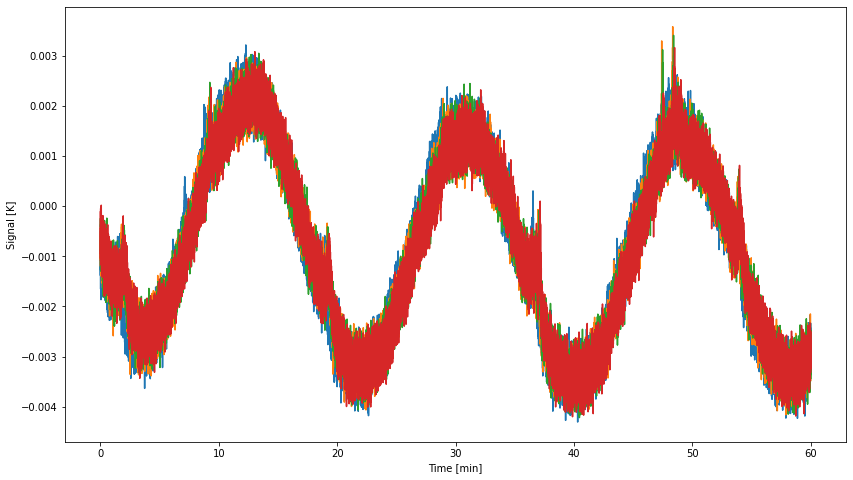

In [11]:
times_min = (sim.observations[0].get_times()-sim.observations[0].start_time.cxcsec)/60.
plt.figure(figsize=(14, 8))
plt.plot(times_min,sim.observations[0].tod[0])
plt.plot(times_min,sim.observations[0].tod[1])
plt.plot(times_min,sim.observations[0].tod[2])
plt.plot(times_min,sim.observations[0].tod[3])

plt.xlabel("Time [min]")
plt.ylabel("Signal [K]")

# Produce a simualted map

In this part, instead, we will simulate 2 detectors of 140 GHz MFT. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version 1.3 (**new!**), and we will simulate 1 year of observation at a lower sampling rate for reduce the memory requrements.

In [12]:
telescope = "MFT"
channel = "M1-140"
detlist = ["001_002_060_45A_140_T",
           "001_003_000_75A_140_B",
          ]

start_time = 0
mission_time_days = 365

imo_version = "v1.3"

# Resolution of the input maps
nside = 256

In [13]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
)

In [14]:
# Load the definition of the instrument (LFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

dets = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = 1.0
    dets.append(det)

[2023-02-15 09:11:08,945 WARNING MPI#0000] Band is not apodized
[2023-02-15 09:11:08,946 WARNING MPI#0000] Band is not apodized


In [15]:
# let's make an input CMB+foreground map
# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    nside=nside,
)

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    detector_list=dets
)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2023-02-15 09:11:08,958 INFO MPI#0000] generating and saving cmb simulations
[2023-02-15 09:11:09,066 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-02-15 09:11:09,066 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-02-15 09:11:09,292 INFO MPI#0000] Access data from /Users/luca/Documents/Universita/litebird/simteam/codes/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_230215.fits
[2023-02-15 09:11:09,297 INFO MPI#0000] NSIDE = 256
[2023-02-15 09:11:09,297 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-15 09:11:09,298 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2023-02-15 09:11:09,578 INFO MPI#0000] generating and saving fg simulations
[2023-02-15 09:11:09,579 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-02-15 09:11:09,583 INFO MPI#0000] NSIDE = 512
[2023-02-15 09:11:09,584 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-15 09:11:09,585 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-02-15 09:11:09,794 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-02-15 09:11:09,798 INFO MPI#0000] NSIDE = 512
[2023-02-15 09:11:09,799 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-15 09:11:09,800 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-02-15 09:11:09,976 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-02-15 09:11:09,979 INFO MPI#0000] NSIDE = 512
[2023-02-15 09:11:09,980 INFO MPI#0000] ORDERING = RING in fits file
[2023-02-15 09:11:09,981 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-02-15 09:11:10,232 INFO MPI#0000] Retrieve data for pysm

In [16]:
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,
)

sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
)
sim.compute_pointings()

In this case we fill the tods with only CMB, Foreground and white noise.

In [17]:
sim.fill_tods(maps)
sim.add_noise('white')

Then we simply bin the observations into maps.

In [18]:
binned = lbs.make_bin_map(obs=sim.observations, nside=nside)

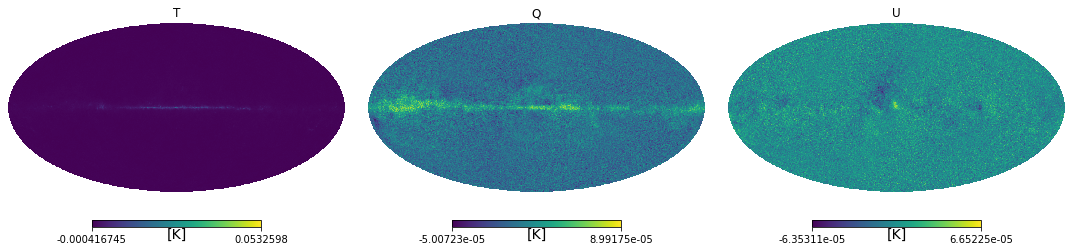

In [19]:
plt.figure(figsize=(15, 8))
hp.mollview(binned[0], sub=131, title="T", unit=r"[K]")
hp.mollview(binned[1], sub=132, title="Q", unit=r"[K]")
hp.mollview(binned[2], sub=133, title="U", unit=r"[K]")